In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from unidip import UniDip
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder


def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    '''
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def plot_MoG_bounds(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    plot_MoG=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if plot_MoG:
            confidence_ellipse(x, z, axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(maxptp, z, axes[1], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
    
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-50, x.max()+50)
            axes[0].set_ylim(z.min()-100, z.max()+100)
            axes[1].set_xlim(0, maxptp.max()+30)
            axes[1].set_ylim(z.min()-100, z.max()+100)
        else:    
            axes[0].set_xlim(data[:,0].min()-10, data[:,0].max()+10)
            axes[0].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
            axes[1].set_xlim(data[:,2].min()-.5, data[:,2].max()+.5)
            axes[1].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('log-ptp')
    axes[1].set_ylabel('z (um)')
    if plot_MoG:
        axes[1].set_title(f'n_units = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1)
        axes[1].spines[ax].set_linewidth(1)

    plt.tight_layout()
    plt.show()

### load data

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [4]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [5]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

In [6]:
thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 384, 30)


In [75]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(thresholded_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(thresholded_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.849 auc: 0.954
choice fold 2 test accuracy: 0.887 auc: 0.973
choice fold 3 test accuracy: 0.887 auc: 0.971
choice fold 4 test accuracy: 0.887 auc: 0.983
choice fold 5 test accuracy: 0.906 auc: 0.985
choice mean of 5-fold cv accuracy: 0.883 auc: 0.973
choice sd of 5-fold cv accuracy: 0.018 auc: 0.011
stimulus fold 1 test accuracy: 0.453 auc: 0.824
stimulus fold 2 test accuracy: 0.302 auc: 0.714
stimulus fold 3 test accuracy: 0.283 auc: 0.740
stimulus fold 4 test accuracy: 0.509 auc: 0.803
stimulus fold 5 test accuracy: 0.472 auc: 0.808
stimulus mean of 5-fold cv accuracy: 0.404 auc: 0.778
stimulus sd of 5-fold cv accuracy: 0.093 auc: 0.043


In [8]:
scales=(1, 1, 50)
log_c=5
x, z, maxptp = spike_features.T
spike_features = np.c_[x * scales[0], z * scales[1], np.log(log_c + maxptp) * scales[2]]

### Split

In [9]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
p_val = 0.01
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    sub_x, sub_z, sub_maxptp = sub_spike_features.T
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        x_modes = UniDip(np.msort(sub_x), alpha=p_val).run()
        n_modes_x = len(x_modes)
        z_modes = UniDip(np.msort(sub_z), alpha=p_val).run()
        n_modes_z = len(z_modes)
        ptp_modes = UniDip(np.msort(sub_maxptp), alpha=p_val).run()
        n_modes_ptp = len(ptp_modes)
        n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            # sub_gmm = GaussianMixture(n_components=n_gaussians, 
            #                   max_iter=1000,
            #                   covariance_type='full',
            #                   init_params='k-means++', 
            #                   warm_start=False, 
            #                   verbose=0)
            sub_gmm = BayesianGaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              n_init=10,
                              covariance_type='full',
                              init_params='k-means++', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 7.0 has 2 modes ...
channel 18.0 has 4 modes ...
channel 29.0 has 2 modes ...
channel 30.0 has 5 modes ...
channel 31.0 has 3 modes ...
channel 42.0 has 3 modes ...
channel 47.0 has 2 modes ...
channel 55.0 has 2 modes ...
channel 70.0 has 2 modes ...
channel 72.0 has 2 modes ...
channel 73.0 has 2 modes ...
channel 74.0 has 3 modes ...
channel 77.0 has 2 modes ...
channel 81.0 has 4 modes ...
channel 85.0 has 2 modes ...
channel 89.0 has 2 modes ...
channel 92.0 has 4 modes ...
channel 94.0 has 4 modes ...
channel 97.0 has 2 modes ...
channel 101.0 has 2 modes ...
channel 103.0 has 2 modes ...
channel 105.0 has 5 modes ...
channel 109.0 has 2 modes ...
channel 110.0 has 4 modes ...
channel 114.0 has 4 modes ...
channel 117.0 has 2 modes ...
channel 126.0 has 2 modes ...
channel 128.0 has 3 modes ...
channel 130.0 has 4 modes ...
channel 133.0 has 3 modes ...
channel 134.0 has 3 modes ...
channel 144.0 has 2 modes ...
channel 145.0 has 2 modes ...
channel 154.0 has 2 modes ...


In [7]:
channel = 305
sub_spike_times = spike_times[spike_channels == channel]
sub_spike_features = spike_features[spike_channels == channel]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

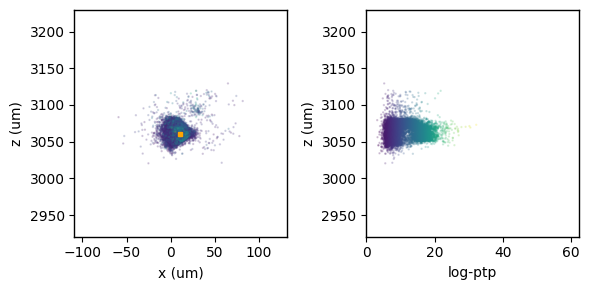

In [8]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=[channel], 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=False,
    figure_size=(6,3)
)

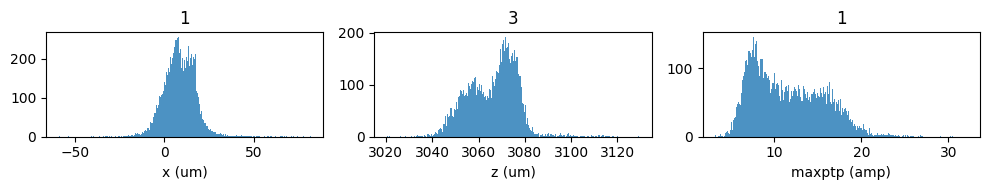

In [9]:
p_val = 0.01
x_modes = UniDip(np.msort(sub_x), alpha=p_val).run()
n_modes_x = len(x_modes)
z_modes = UniDip(np.msort(sub_z), alpha=p_val).run()
n_modes_z = len(z_modes)
ptp_modes = UniDip(np.msort(sub_maxptp), alpha=p_val).run()
n_modes_ptp = len(ptp_modes)
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [10]:
# initialize MoG using kmeans
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_features)
sub_labels = sub_gmm.predict(sub_spike_features)

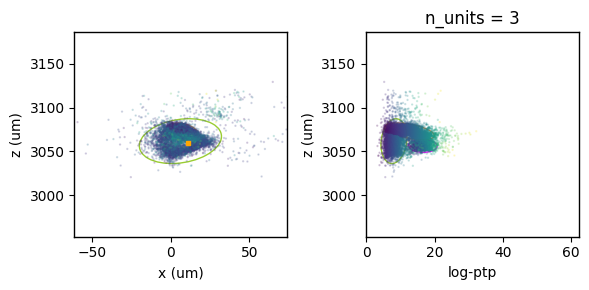

In [11]:
plot_MoG_bounds(
    data=sub_spike_features, 
    labels=sub_labels, 
    labels_display=np.unique(sub_labels), 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=True,
    figure_size=(6,3),
    n_spikes = 1_000
)

In [10]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [11]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(8):
    print(f'loading batch {i+1} ..')
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..
loading batch 6 ..
loading batch 7 ..
loading batch 8 ..


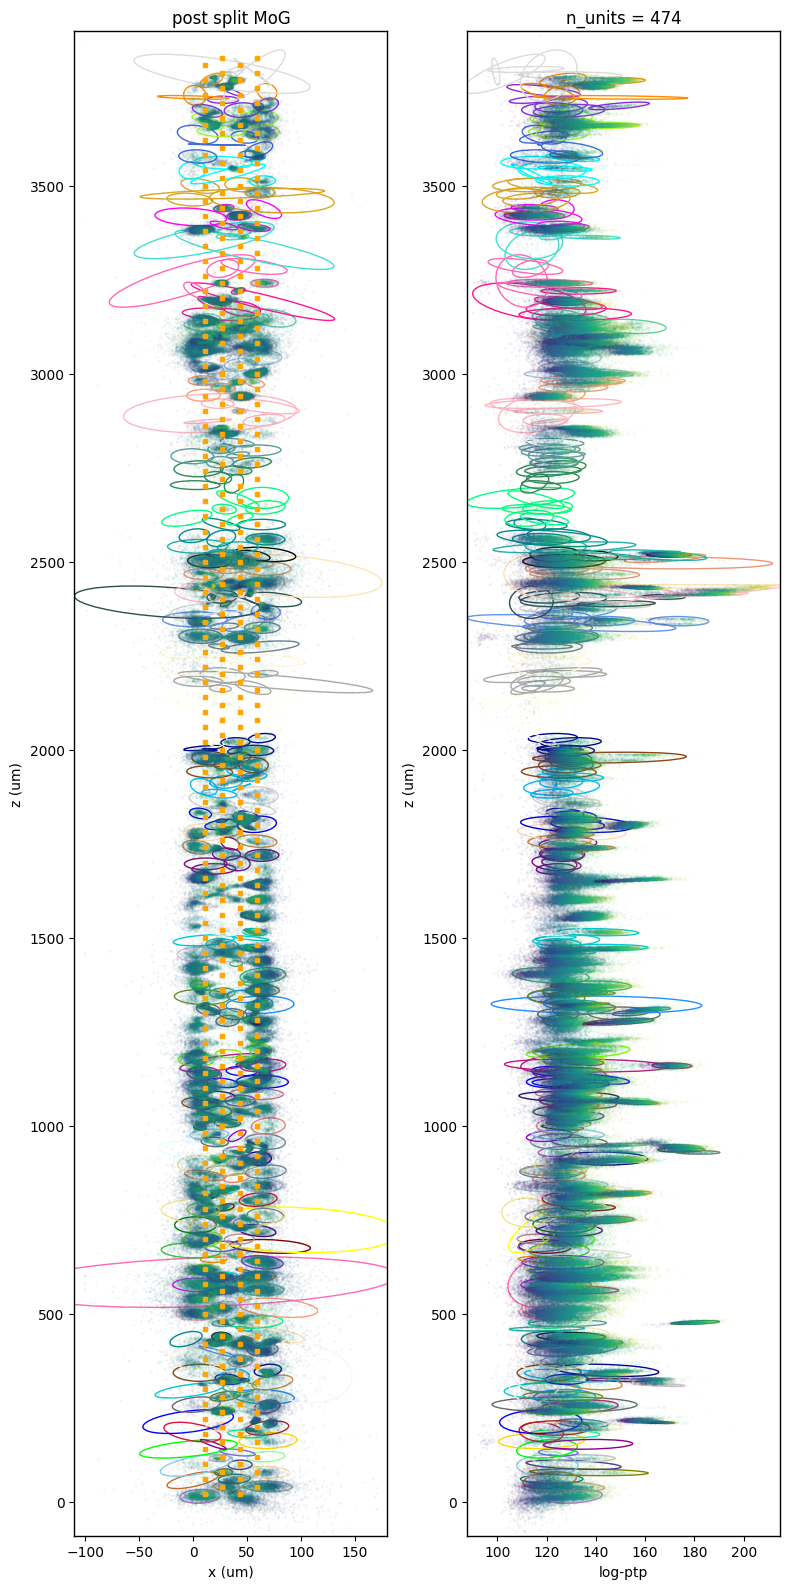

In [12]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [13]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/post_split_gmm'
np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)

In [76]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 474, 30)


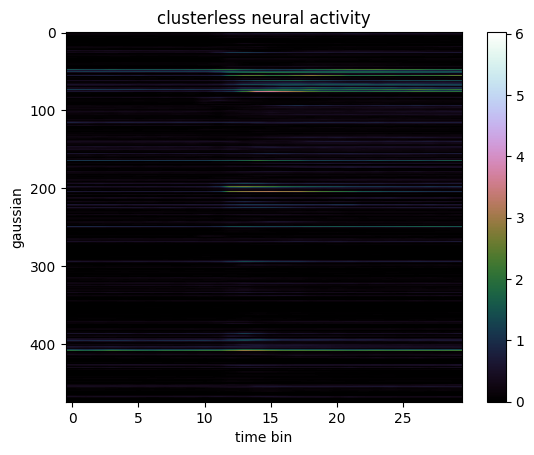

In [77]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [78]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    choices, 
    behave_type='choice', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

choice fold 1 test accuracy: 0.868 auc: 0.927
choice fold 2 test accuracy: 0.943 auc: 0.983
choice fold 3 test accuracy: 0.925 auc: 0.975
choice fold 4 test accuracy: 0.925 auc: 0.987
choice fold 5 test accuracy: 0.925 auc: 0.980
choice mean of 5-fold cv accuracy: 0.917 auc: 0.970
choice sd of 5-fold cv accuracy: 0.026 auc: 0.022


In [79]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    one_hot_stimuli, 
    behave_type='stimulus', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

stimulus fold 1 test accuracy: 0.509 auc: 0.835
stimulus fold 2 test accuracy: 0.245 auc: 0.714
stimulus fold 3 test accuracy: 0.302 auc: 0.743
stimulus fold 4 test accuracy: 0.509 auc: 0.809
stimulus fold 5 test accuracy: 0.434 auc: 0.821
stimulus mean of 5-fold cv accuracy: 0.400 auc: 0.784
stimulus sd of 5-fold cv accuracy: 0.108 auc: 0.047


merge

In [18]:
def kl_mvn(mu0, mu1, S0, S1):
    N = mu0.shape[0]
    inv_S1 = np.linalg.inv(S1)
    diff = mu1 - mu0
    tr_term   = np.trace(inv_S1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) 
    quad_term = diff.T @ np.linalg.inv(S1) @ diff 
    return .5 * (tr_term + det_term + quad_term - N) 

def symmetric_kl(mu0, mu1, S0, S1):
    kl1 = kl_mvn(mu0, mu1, S0, S1)
    kl2 = kl_mvn(mu1, mu0, S1, S0)
    return np.mean([kl1, kl2])

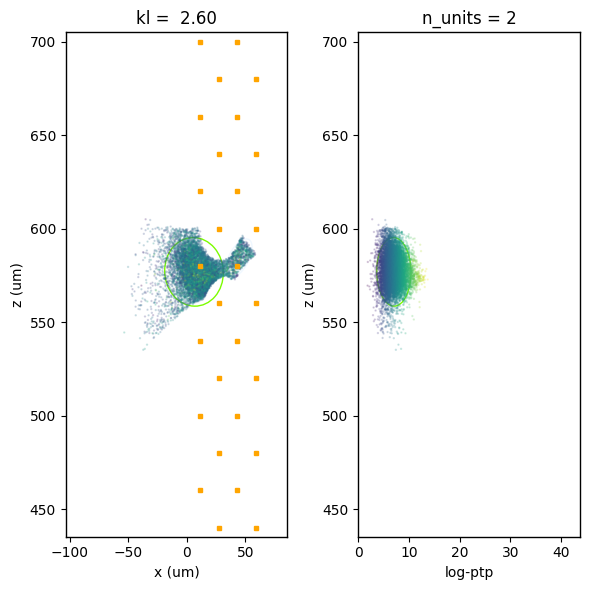

In [24]:
labels = [70, 71] 

kl = symmetric_kl(mu0 = post_split_gmm.means_[labels[0]], 
       mu1 = post_split_gmm.means_[labels[1]], 
       S0 = post_split_gmm.covariances_[labels[0]], 
       S1 = post_split_gmm.covariances_[labels[1]])

plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=labels, 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [25]:
mask = np.logical_or(spike_labels == labels[0], spike_labels == labels[1])
sub_spike_times = spike_times[mask]
sub_spike_features = spike_features[mask]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

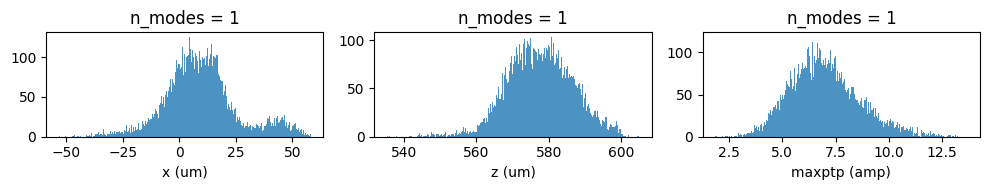

In [26]:
p_val = 0.01,
n_modes_x = len(UniDip(np.msort(sub_x), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_z), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_maxptp), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(f'n_modes = {n_modes_x}')
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(f'n_modes = {n_modes_z}')
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(f'n_modes = {n_modes_ptp}')
plt.tight_layout()
plt.show()

### roll out on all pairs of gaussians ...

In [19]:
def pairwise_symmetric_kl(means, covs):
    m = len(means)
    D = np.ones((m,m)) * np.inf
    pairs = []
    for i in range(m):
        for j in range(m):
            if i != j:
                if set([i,j]) not in pairs:
                    pairs.append(set([i,j]))
                    kl = symmetric_kl(mu0 = means[i], 
                                       mu1 = means[j], 
                                       S0 = covs[i], 
                                       S1 = covs[j])
                    D[i, j] = kl
                    if np.logical_and(i % 50 == 0, j % 100 == 0):
                        print(f'calc kl for pair ({i}, {j}) ...')
            elif i == j:
                D[i, j] = np.inf  # exclude self-connection
    return D

In [20]:
kl_div = pairwise_symmetric_kl(post_split_gmm.means_, post_split_gmm.covariances_)

calc kl for pair (0, 100) ...
calc kl for pair (0, 200) ...
calc kl for pair (0, 300) ...
calc kl for pair (0, 400) ...
calc kl for pair (50, 100) ...
calc kl for pair (50, 200) ...
calc kl for pair (50, 300) ...
calc kl for pair (50, 400) ...
calc kl for pair (100, 200) ...
calc kl for pair (100, 300) ...
calc kl for pair (100, 400) ...
calc kl for pair (150, 200) ...
calc kl for pair (150, 300) ...
calc kl for pair (150, 400) ...
calc kl for pair (200, 300) ...
calc kl for pair (200, 400) ...
calc kl for pair (250, 300) ...
calc kl for pair (250, 400) ...
calc kl for pair (300, 400) ...
calc kl for pair (350, 400) ...


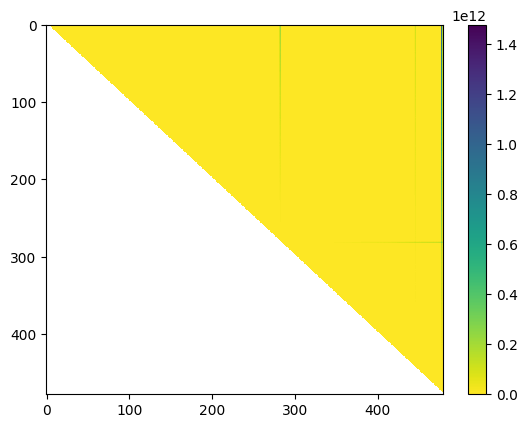

In [21]:
plt.imshow(kl_div, aspect='auto', cmap='viridis_r')
plt.colorbar()
plt.show()

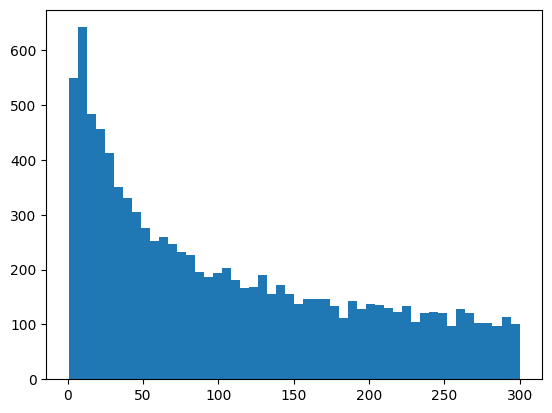

In [22]:
plt.hist(kl_div[kl_div < 300].flatten(), 50);

In [33]:
np.argwhere(np.logical_and(kl_div > 29, kl_div < 30))[:3]

array([[ 5, 12],
       [ 9, 16],
       [12, 15]])

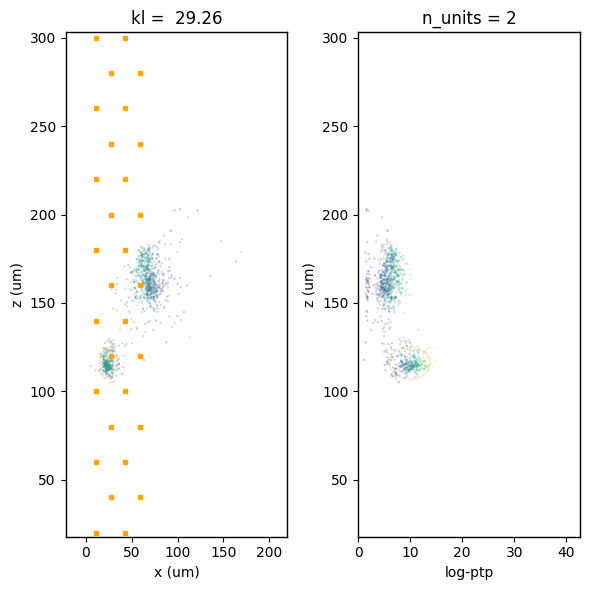

In [34]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=[12, 15], 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl_div[12, 15]: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [80]:
merge_candidates = np.argwhere(kl_div < 2.5) 

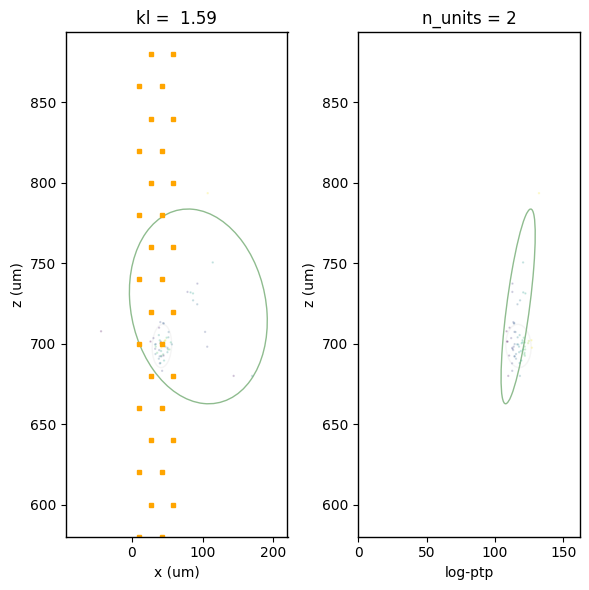

In [62]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=merge_candidates[10], 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl_div[merge_candidates[0][0], merge_candidates[0][1]]: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [81]:
post_split_labels = spike_labels.copy()
pre_merge_labels = set(np.unique(post_split_labels)).difference(set(np.unique(merge_candidates)))
print(f'keep {len(pre_merge_labels)} gaussians and merge {len(np.unique(merge_candidates))} gaussians ...')

pre_merge_weights = np.vstack([post_split_gmm.weights_[i] for i in pre_merge_labels]).squeeze()
pre_merge_means = np.vstack([post_split_gmm.means_[i] for i in pre_merge_labels])
pre_merge_covariances = np.stack([post_split_gmm.covariances_[i] for i in pre_merge_labels])

pre_merge_gmm = GaussianMixture(n_components = len(pre_merge_weights), covariance_type='full')
pre_merge_gmm.weights_ = pre_merge_weights
pre_merge_gmm.means_ = pre_merge_means
pre_merge_gmm.covariances_ = pre_merge_covariances
pre_merge_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(pre_merge_covariances))

keep 373 gaussians and merge 105 gaussians ...


In [82]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(merge_candidates)
merge_cliques = sorted(nx.connected_components(G), key = len, reverse=True)

In [83]:
len(merge_cliques)

36

In [84]:
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []

for clique in merge_cliques:
    print('merging '+ str(clique) + ' ...')
    sub_spike_features = [] 
    for unit in clique:
        sub_spike_features.append([spike_features[post_split_labels == unit]])
    sub_spike_features = np.hstack(sub_spike_features).squeeze()
    sub_gmm = BayesianGaussianMixture(n_components=1, 
                                      init_params='k-means++',
                                      n_init=10)
    sub_gmm.fit(sub_spike_features)
    sub_labels = sub_gmm.predict(sub_spike_features)
    sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
    sub_weights_lst.append(sub_weights)
    sub_means_lst.append(sub_gmm.means_)
    sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

merging {289, 291, 292, 293, 294, 295, 296, 287} ...
merging {326, 331, 332, 335, 336, 338, 339, 341} ...
merging {401, 403, 404, 407, 408, 411, 413} ...
merging {80, 82, 83, 84, 86, 94} ...
merging {57, 58, 59, 61, 62} ...
merging {66, 68, 70, 71, 72} ...
merging {8, 4, 5} ...
merging {44, 46, 47} ...
merging {240, 238, 247} ...
merging {256, 258, 255} ...
merging {345, 337, 340} ...
merging {432, 429, 430} ...
merging {17, 22} ...
merging {41, 43} ...
merging {50, 51} ...
merging {65, 63} ...
merging {107, 101} ...
merging {132, 133} ...
merging {162, 159} ...
merging {177, 175} ...
merging {200, 201} ...
merging {208, 206} ...
merging {228, 230} ...
merging {250, 252} ...
merging {266, 269} ...
merging {297, 299} ...
merging {349, 350} ...
merging {362, 364} ...
merging {369, 367} ...
merging {376, 377} ...
merging {393, 391} ...
merging {396, 399} ...
merging {412, 414} ...
merging {416, 418} ...
merging {448, 450} ...
merging {457, 459} ...


In [85]:
post_merge_weights = np.vstack([pre_merge_gmm.weights_.reshape(-1,1), sub_weights.reshape(-1,1)]).flatten()
post_merge_means = np.vstack([pre_merge_gmm.means_, sub_means])
post_merge_covs = np.vstack([pre_merge_gmm.covariances_, sub_covs])

post_merge_gmm = GaussianMixture(n_components=len(post_merge_weights), 
                                 covariance_type='full')
post_merge_gmm.weights_ = post_merge_weights
post_merge_gmm.means_ = post_merge_means
post_merge_gmm.covariances_ = post_merge_covs
post_merge_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(post_merge_covs))

In [86]:
post_merge_labels = []
post_merge_probs = []
offset = 100_000
for i in range(8):
    print(f'loading batch {i+1} ..')
    post_merge_labels.extend(post_merge_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    post_merge_probs.extend(post_merge_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
post_merge_labels = np.array(post_merge_labels)
post_merge_probs = np.array(post_merge_probs)

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..
loading batch 6 ..
loading batch 7 ..
loading batch 8 ..


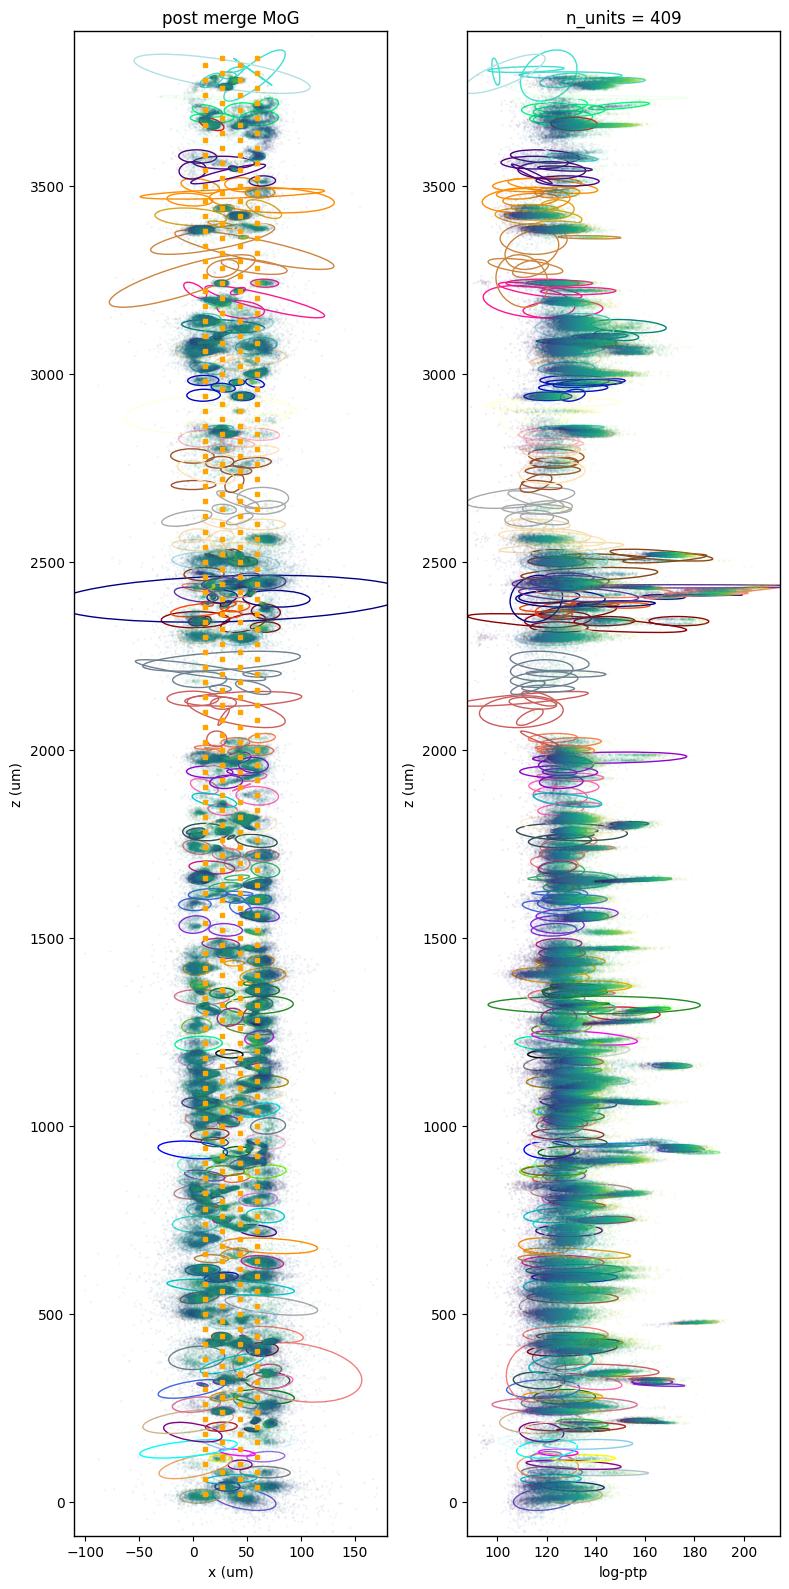

In [87]:
plot_MoG_bounds(
    data=spike_features, 
    labels=post_merge_labels, 
    labels_display=np.unique(post_merge_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post merge MoG'
)

In [88]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/post_merge_gmm'
np.save(gmm_name + '_weights', post_merge_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', post_merge_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', post_merge_gmm.covariances_, allow_pickle=False)

post_merge_spike_train = np.c_[spike_times, post_merge_labels]
np.save(gmm_name + '_spike_train.npy', post_merge_spike_train, allow_pickle=False)

In [89]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, post_merge_labels, post_merge_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 409, 30)


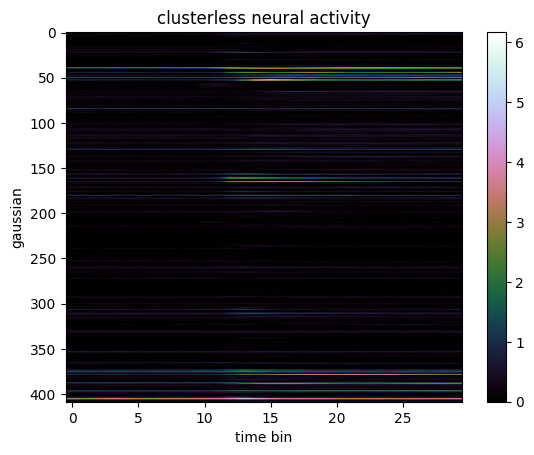

In [90]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [91]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    choices, 
    behave_type='choice', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

choice fold 1 test accuracy: 0.868 auc: 0.935
choice fold 2 test accuracy: 0.925 auc: 0.983
choice fold 3 test accuracy: 0.925 auc: 0.967
choice fold 4 test accuracy: 0.962 auc: 0.983
choice fold 5 test accuracy: 0.925 auc: 0.974
choice mean of 5-fold cv accuracy: 0.921 auc: 0.968
choice sd of 5-fold cv accuracy: 0.030 auc: 0.018


In [92]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    one_hot_stimuli, 
    behave_type='stimulus', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

stimulus fold 1 test accuracy: 0.509 auc: 0.835
stimulus fold 2 test accuracy: 0.340 auc: 0.707
stimulus fold 3 test accuracy: 0.340 auc: 0.747
stimulus fold 4 test accuracy: 0.528 auc: 0.800
stimulus fold 5 test accuracy: 0.472 auc: 0.813
stimulus mean of 5-fold cv accuracy: 0.438 auc: 0.780
stimulus sd of 5-fold cv accuracy: 0.082 auc: 0.047
